In [1]:
import qiskit.tools.jupyter
%qiskit_version_table

### Classical Preparation

In [2]:
# import common packages
import numpy as np
from qiskit import Aer

# lib from Qiskit Aqua
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver ,ExactEigensolver
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.components.optimizers import COBYLA

# lib from Qiskit Aqua Chemistry
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PSI4Driver
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

In [3]:
psi4_h2_config = '''
molecule mol {{
   0 1
   H   0.0 0.0 0.0
   H   0.0 0.0 {}
}}

set {{
      basis sto-3g
      scf_type pk
      reference {}
}}
'''
R=0.74
driver = PSI4Driver(config=psi4_h2_config.format(R,'rhf'))    
molecule=driver.run()

In [4]:
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# of electrons: {}".format(num_particles))
print("# of spin orbitals: {}".format(num_spin_orbitals))

HF energy: -1.8318636461214002
# of electrons: 2
# of spin orbitals: 4


### Generate the Qubit Hamiltonian 

In [5]:
map_type = 'jordan_wigner'

qubit_reduction = True if map_type == '' else False

ferOp = FermionicOperator(h1=h1, h2=h2)
ferOp._convert_to_interleaved_spins()
qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
qubitOp.chop(10**-10)

print(qubitOp.print_details())
print(qubitOp)

IIII	(-0.8121706073608693+0j)
IIIZ	(0.17141282639402397+0j)
IIZI	(0.17141282639402397+0j)
IZII	(-0.22343153674663999+0j)
ZIII	(-0.22343153674663993+0j)
IZIZ	(0.12062523481381834+0j)
IIZZ	(0.16868898168693283+0j)
XXYY	(-0.04530261550868934+0j)
YXXY	(0.04530261550868934+0j)
XYYX	(0.04530261550868934+0j)
YYXX	(-0.04530261550868934+0j)
ZIIZ	(0.16592785032250768+0j)
ZIZI	(0.12062523481381834+0j)
IZZI	(0.16592785032250768+0j)
ZZII	(0.17441287610651623+0j)

Representation: paulis, qubits: 4, size: 15


### Classical Eigensolver (code problem here)

In [ ]:
#exact_eigensolver = ExactEigensolver(qubitOp)
#ret = exact_eigensolver.run()
#print('The computed energy is: {:.12f}'.format(ret.eigenvalue.real))

## Now Quantum In

#### Step 1: Ansatz Construction

<center> $U(\theta)=e^{-i\theta X_3 X_2 X_1 Y_0}$

In [6]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit import ParameterVector
from qiskit.tools.visualization import circuit_drawer
from math import pi

In [7]:
def ucc_ansatz(theta):
    ucc = QuantumCircuit(4)
    
    # Generate HF state
    ucc.x(0)
    ucc.x(1)
    
    ucc.barrier()
    ucc.rx(-pi/2,0)
    ucc.h([1,2,3])
    for i in range(3):
        ucc.cx(i, i+1)      
        
    ucc.rz(theta*2,3)
    
    for i in reversed(range(3)):
        ucc.cx(i, i+1)            
    ucc.barrier()    
    ucc.rx(+pi/2,0)
    ucc.h([1,2,3])
    ucc.barrier()
    return ucc

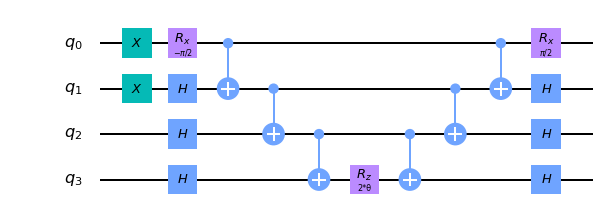

In [8]:
from qiskit.circuit import Parameter
theta = Parameter('θ')
var_circ=ucc_ansatz(theta)
var_circ.draw(output='mpl',plot_barriers=0)

### Qiskit Default

In [9]:
optimizer = COBYLA(maxiter=100)
backend = Aer.get_backend('statevector_simulator')
vqe = VQE(operator=qubitOp, optimizer=optimizer, quantum_instance=backend)

In [10]:
vqe.var_form = var_circ
result = vqe.compute_minimum_eigenvalue()
print('VQE:', result.eigenvalue.real)

VQE: -1.85238813920865
